# **SST-3 Sentiment Analysis Project - Team 33**
**Step 1: Import Libraries**

In [14]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

nltk.download('stopwords')
from nltk.corpus import stopwords

# Keep negations
stop_words = set(stopwords.words('english')) - {"not", "no"}


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
!ls

dev.txt  sample_data  test.txt	train.txt


**2. Parse SST-3 Tree Format**

In [16]:
def parse_sst_tree_line(line):
    label_match = re.match(r'\((\d)', line)
    if not label_match:
        return None, None
    label = int(label_match.group(1))

    if label == 0:
        sentiment = "Negative"
    elif label == 1:
        sentiment = "Neutral"
    else:
        sentiment = "Positive"

    text = re.sub(r'[\(\)\d]', '', line).strip()
    return text, sentiment

def sst_to_df(file_path):
    texts, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            text, sentiment = parse_sst_tree_line(line)
            if text:
                texts.append(text)
                labels.append(sentiment)
    return pd.DataFrame({'review': texts, 'sentiment': labels})
# Load train, dev, test sets
train_df = sst_to_df("train.txt")
dev_df = sst_to_df("dev.txt")
test_df = sst_to_df("test.txt")

# Combine train + dev for training
full_train_df = pd.concat([train_df, dev_df], ignore_index=True)
print("Training samples:", full_train_df.shape[0])
print("Test samples:", test_df.shape[0])
full_train_df.head()

Training samples: 9645
Test samples: 2210


,review,sentiment
0,The Rock is destined to be the ...,Positive
1,The gorgeously elaborate continuation ...,Positive
2,Singer\/composer Bryan Adams contributes ...,Positive
3,You 'd think by now America would ...,Positive
4,Yet the act is still charming here .,Positive


**3. Text Preprocessing**

In [17]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)       # Remove numbers/symbols
    text = text.lower()
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

full_train_df['cleaned'] = full_train_df['review'].apply(clean_text)
test_df['cleaned'] = test_df['review'].apply(clean_text)

**4. Feature Extraction - TF-IDF**

In [18]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
X_train = tfidf.fit_transform(full_train_df['cleaned'])
y_train = full_train_df['sentiment']

X_test = tfidf.transform(test_df['cleaned'])
y_test = test_df['sentiment']

**5. Train Logistic Regression Model**

In [19]:
lr_model = LogisticRegression(max_iter=500, class_weight='balanced')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("\n=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression Results ===
Accuracy: 0.6257918552036199
              precision    recall  f1-score   support

    Negative       0.31      0.38      0.34       279
     Neutral       0.46      0.45      0.46       633
    Positive       0.79      0.76      0.78      1298

    accuracy                           0.63      2210
   macro avg       0.52      0.53      0.53      2210
weighted avg       0.64      0.63      0.63      2210



**6. Train SVM Model**

In [20]:
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("\n=== SVM Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


=== SVM Results ===
Accuracy: 0.6149321266968326
              precision    recall  f1-score   support

    Negative       0.28      0.39      0.33       279
     Neutral       0.47      0.48      0.47       633
    Positive       0.81      0.73      0.77      1298

    accuracy                           0.61      2210
   macro avg       0.52      0.53      0.52      2210
weighted avg       0.65      0.61      0.63      2210



**7. Confusion Matrix Visualization**

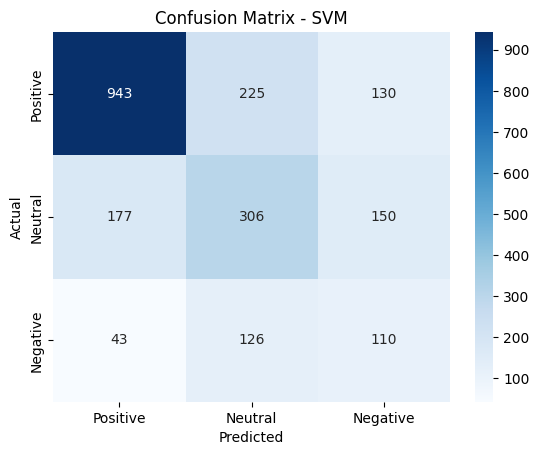

In [21]:
cm = confusion_matrix(y_test, y_pred_svm, labels=["Positive","Neutral","Negative"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Positive","Neutral","Negative"], yticklabels=["Positive","Neutral","Negative"])
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**8. Word Cloud Visualization**

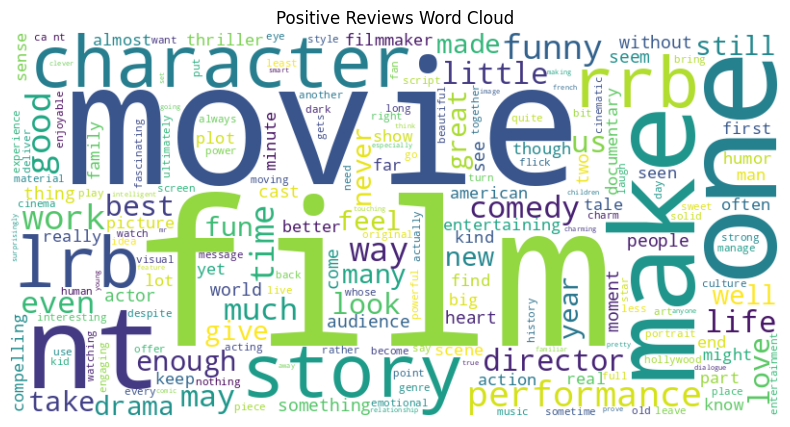

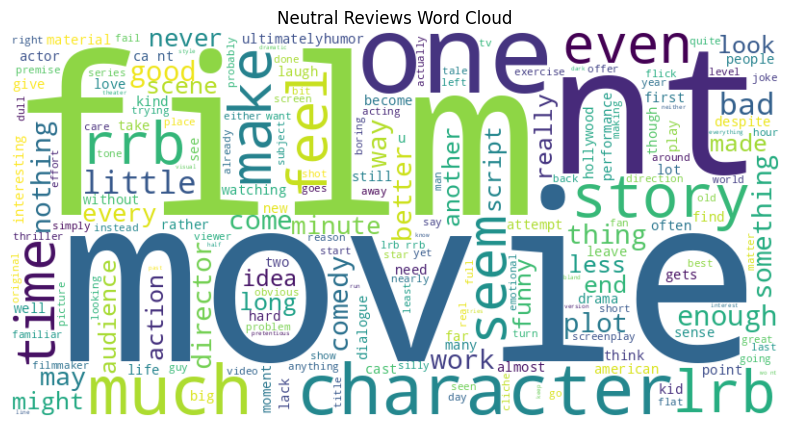

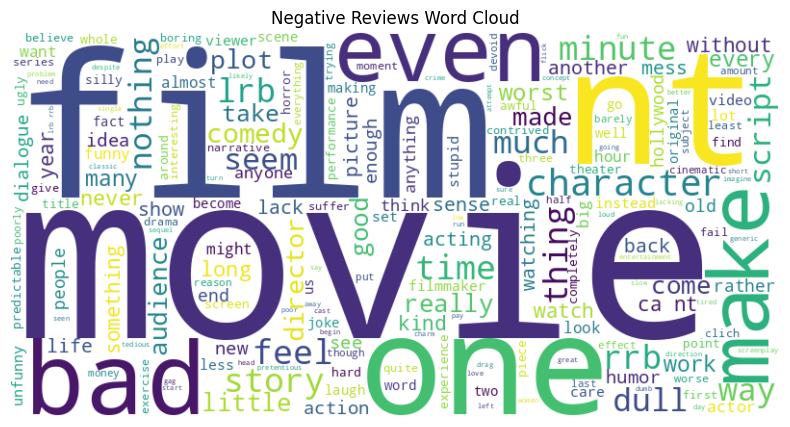

In [22]:
for sentiment in ["Positive","Neutral","Negative"]:
    text = " ".join(full_train_df[full_train_df['sentiment']==sentiment]['cleaned'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment} Reviews Word Cloud")
    plt.show()

**9. Predict on New Reviews**

In [23]:
def predict_sentiment(review):
    clean = clean_text(review)
    vec = tfidf.transform([clean])
    pred = svm_model.predict(vec)[0]
    return pred

# Test predictions
print("\nSample Predictions:")
print(predict_sentiment("I absolutely loved this movie, it was fantastic!"))
print(predict_sentiment("It was okay, not very exciting but not bad either."))
print(predict_sentiment("I really disliked this movie, it was terrible."))


Sample Predictions:
Positive
Negative
Negative
